In [9]:
import json
import numpy as np
from pprint import pprint as pp
import matplotlib.pyplot as plt


In [55]:
def ci95_filter(logs_raw_json: str) -> dict:

    with open(logs_raw_json, "r") as j:
        logs_raw_dict = json.load(j)

    ci95_logs: dict = {}

    for key, data in logs_raw_dict.items():
        ut = np.array([d[0] for d in data])
        kt = np.array([d[1] for d in data])
        df = np.array([d[2] for d in data])

        ut_normalized = (ut - ut.min()) / (ut.max() - ut.min())
        kt_normalized = (kt - kt.min()) / (kt.max() - kt.min())
        df_normalized = (df - df.min()) / (df.max() - df.min())

        ut_bound = (ut_normalized.mean() - ut_normalized.std(), ut_normalized.mean() + ut_normalized.std())
        kt_bound = (kt_normalized.mean() - kt_normalized.std(), kt_normalized.mean() + kt_normalized.std())
        df_bound = (df_normalized.mean() - df_normalized.std(), df_normalized.mean() + df_normalized.std())

        # print(f"[{key}] usertime    : mean = {ut_normalized.mean()}, \tstd = {ut_normalized.std()}")
        # print(f"[{key}] kerneltime  : mean = {kt_normalized.mean()}, \tstd = {kt_normalized.std()}")
        # print(f"[{key}] difftime    : mean = {df_normalized.mean()}, \tstd = {df_normalized.std()}")

        # remove outlier (95 CI)
        ut_ci95 = np.array([ut[i] for i in range(len(data)) if ut_bound[0] <= ut_normalized[i] <= ut_bound[1]])
        kt_ci95 = np.array([kt[i] for i in range(len(data)) if kt_bound[0] <= kt_normalized[i] <= kt_bound[1]])
        df_ci95 = np.array([df[i] for i in range(len(data)) if df_bound[0] <= df_normalized[i] <= df_bound[1]])

        # print(f"ut_ci95 = {ut_ci95}, kt_ci95 = {kt_ci95}, df_ci95 = {df_ci95}")

        ci95_logs[key] = {"ut": ut_ci95, "kt": kt_ci95, "df": df_ci95}

    return ci95_logs


In [78]:
def plot_result(ci_data_dict: dict, dst: str):

    fig, ax1 = plt.subplots(1, 1, sharey=True, figsize=(20, 10))

    for key, ci_data_style in ci_data_dict.items():
        ci_data, style, repeats, start, end = ci_data_style

        title = f'fibdrv-{key}-r{repeats}-[{start}:{end}]'

        x = [i for i in range(len(ci_data))]
        uts = np.array([data['ut'].mean() for _, data in ci_data.items()])
        kts = np.array([data['kt'].mean() for _, data in ci_data.items()])
        dfs = np.array([data['df'].mean() for _, data in ci_data.items()])

        ax1.set_title(title, fontsize=24)
        ax1.set_xlabel(r'$n_{th}$ fibonacci', fontsize=24)
        ax1.set_ylabel('time (ns)', fontsize=24)

        if len(ci_data_dict) == 1:
            key = ''
        ax1.plot(x, uts, f'r{style}', markersize=3, label=f'user {key}')
        ax1.plot(x, kts, f'g{style}', markersize=3, label=f'kernel {key}')
        ax1.plot(x, dfs, f'b{style}', markersize=3, label=f'kernel to user {key}')

    ax1.legend(fontsize=16, bbox_to_anchor=(1, 1))
    plt.show()

    if not dst:
        dst = title + '.png'
    fig.savefig(dst, bbox_inches='tight')


In [86]:
logs_raw_m0 = "log-m0_0-92_r1000.json"
# logs_raw_m1 = "log-m1_0-92_r1000.json"
# logs_raw_m1big = "log-m1_0-2000_r100.json"
# logs_raw_m2 = "log-m2_0-92_r1000.json"
# logs_raw_m2b = "log-m2b_0-92_r1000.json"

m0_95ci = ci95_filter(logs_raw_m0)
# m1_95ci = ci95_filter(logs_raw_m1)
# m1big_95ci = ci95_filter(logs_raw_m1big)
# m2_95ci = ci95_filter(logs_raw_m2)
# m2b_95ci = ci95_filter(logs_raw_m2b)


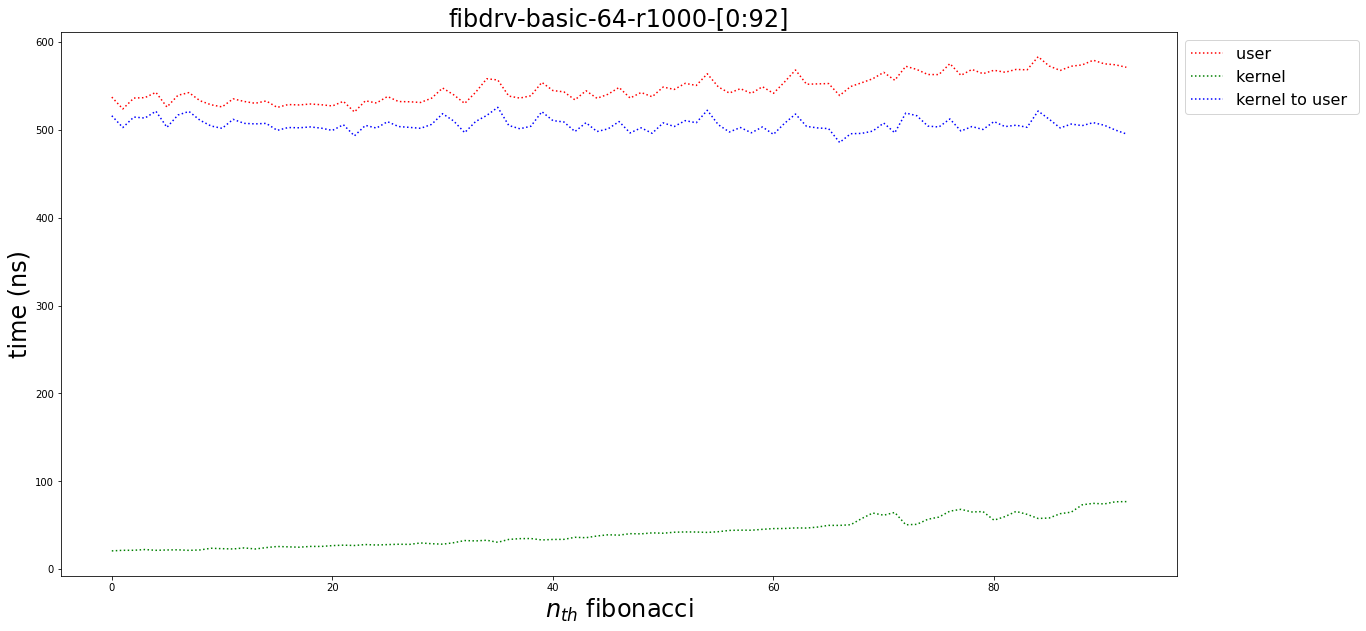

In [87]:
ci_data_dict = {
    "basic-64": (m0_95ci, ':', 1000, 0, 92),
    # "basic-big": (m1big_95ci, ':', 100, 0, 2000),
    # "fast-64-branchless": (m2_95ci, ':', 1000, 0, 92),
    # "fast-64": (m2b_95ci, '--', 1000, 0, 92),
}
plot_result(ci_data_dict, None)
